#### Setup & Configuration

Imports & Logging Setup

In [1]:
import os
import yaml
import logging
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Subset, ConcatDataset, DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd


In [2]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger()


#### Dataset Loading and Batching

Download CIFAR-10 and apply transforms

In [3]:
transform = transforms.Compose([transforms.ToTensor()])

full_train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)


100%|██████████| 170M/170M [00:04<00:00, 41.6MB/s]


In [5]:
import yaml

with open("config.yaml", "r") as f:
    config = yaml.safe_load(f)

configurations = config["experiment_configs"]

if config["device"] == "auto":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
else:
    device = torch.device(config["device"])

print(f"Using device: {device}")


Using device: cuda


Split training data into batches

In [6]:
def split_into_batches(dataset, batch_size):
    total_samples = len(dataset)
    num_batches = total_samples // batch_size
    batches = []

    for i in range(num_batches):
        indices = list(range(i * batch_size, (i + 1) * batch_size))
        batches.append(Subset(dataset, indices))

    return batches

train_batches = split_into_batches(full_train_dataset, batch_size=config["batch_size"])
logger.info(f"{len(train_batches)} training batches created (batch size: {config['batch_size']})")


Helper function to split dataset into batches

In [7]:
def split_into_batches(dataset, batch_size):
    total_samples = len(dataset)
    num_batches = total_samples // batch_size
    batches = []

    for i in range(num_batches):
        start = i * batch_size
        end = start + batch_size
        batch_indices = list(range(start, end))
        batch_subset = Subset(dataset, batch_indices)
        batches.append(batch_subset)

    return batches


#### CNN Model Definition

Define a simple CNN for CIFAR-10

In [9]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # Output: [B, 32, 16, 16]
        x = self.pool(F.relu(self.conv2(x)))  # Output: [B, 64, 8, 8]
        x = self.dropout(x)
        x = x.view(-1, 64 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


#### Training and Evaluation Utilities

Training function

In [10]:
def train(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

    avg_loss = total_loss / len(loader)
    accuracy = correct / total
    return avg_loss, accuracy


Evaluation function

In [11]:
def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    y_true, y_pred = [], []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    avg_loss = total_loss / len(loader)
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_true, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)

    return avg_loss, accuracy, precision, recall, f1


#### Multiple Training Configurations

Define results list

In [12]:

results = []


Define one-run experiment function

In [13]:
def run_experiment(train_batches_ids, val_batches_ids, name):
    selected_train = [train_batches[i] for i in train_batches_ids]
    selected_val = [train_batches[i] for i in val_batches_ids]

    train_dataset = ConcatDataset(selected_train)
    val_dataset = ConcatDataset(selected_val)

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

    model = SimpleCNN().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=config["learning_rate"])
    criterion = nn.CrossEntropyLoss()

    for epoch in range(config["train_epochs"]):
        print(f"[{name}] Epoch {epoch + 1}/{config['train_epochs']}")
        train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)
        val_loss, val_acc, val_prec, val_rec, val_f1 = evaluate(model, val_loader, criterion, device)

    test_loss, test_acc, test_prec, test_rec, test_f1 = evaluate(model, test_loader, criterion, device)

    results.append({
        "config": name,
        "train_size": len(train_dataset),
        "val_size": len(val_dataset),
        "test_acc": round(test_acc, 4),
        "test_f1": round(test_f1, 4),
        "test_prec": round(test_prec, 4),
        "test_rec": round(test_rec, 4)
    })

    logger.info(f"[{name}] Test Accuracy: {test_acc:.4f}, F1: {test_f1:.4f}")


Run all experiments

In [14]:
for cfg in configurations:
    print(f"Running configuration: {cfg['name']}...")
    run_experiment(cfg["train_batches"], cfg["val_batches"], cfg["name"])
    print(f"Finished {cfg['name']}")


Running configuration: 1 batch...
[1 batch] Epoch 1/30
[1 batch] Epoch 2/30
[1 batch] Epoch 3/30
[1 batch] Epoch 4/30
[1 batch] Epoch 5/30
[1 batch] Epoch 6/30
[1 batch] Epoch 7/30
[1 batch] Epoch 8/30
[1 batch] Epoch 9/30
[1 batch] Epoch 10/30
[1 batch] Epoch 11/30
[1 batch] Epoch 12/30
[1 batch] Epoch 13/30
[1 batch] Epoch 14/30
[1 batch] Epoch 15/30
[1 batch] Epoch 16/30
[1 batch] Epoch 17/30
[1 batch] Epoch 18/30
[1 batch] Epoch 19/30
[1 batch] Epoch 20/30
[1 batch] Epoch 21/30
[1 batch] Epoch 22/30
[1 batch] Epoch 23/30
[1 batch] Epoch 24/30
[1 batch] Epoch 25/30
[1 batch] Epoch 26/30
[1 batch] Epoch 27/30
[1 batch] Epoch 28/30
[1 batch] Epoch 29/30
[1 batch] Epoch 30/30
Finished 1 batch
Running configuration: 2 batches...
[2 batches] Epoch 1/30
[2 batches] Epoch 2/30
[2 batches] Epoch 3/30
[2 batches] Epoch 4/30
[2 batches] Epoch 5/30
[2 batches] Epoch 6/30
[2 batches] Epoch 7/30
[2 batches] Epoch 8/30
[2 batches] Epoch 9/30
[2 batches] Epoch 10/30
[2 batches] Epoch 11/30
[2 batc

#### Results Visualization

In [15]:
df = pd.DataFrame(results)
display(df)


,config,train_size,val_size,test_acc,test_f1,test_prec,test_rec
0,1 batch,10000,10000,0.6334,0.6326,0.6337,0.6334
1,2 batches,20000,10000,0.6686,0.6694,0.6750,0.6686
2,3 batches,30000,10000,0.6875,0.6882,0.6932,0.6875
3,4 batches,40000,10000,0.7174,0.7185,0.7218,0.7174


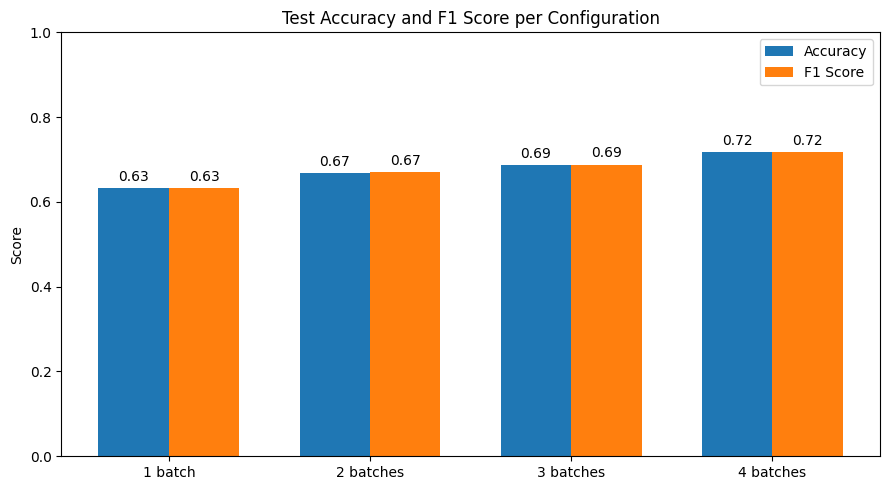

In [16]:
import numpy as np

labels = df["config"]
accuracy = df["test_acc"]
f1_score_ = df["test_f1"]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(9, 5))
rects1 = ax.bar(x - width/2, accuracy, width, label='Accuracy')
rects2 = ax.bar(x + width/2, f1_score_, width, label='F1 Score')

ax.set_ylabel('Score')
ax.set_title('Test Accuracy and F1 Score per Configuration')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim(0, 1.0)
ax.legend()

for rect in rects1 + rects2:
    height = rect.get_height()
    ax.annotate(f'{height:.2f}', xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3), textcoords="offset points",
                ha='center', va='bottom')

plt.tight_layout()
plt.show()
